## Code for all transitions analysis

In [1]:
import numpy as np
import xarray as xr
from itertools import product
import hexMinisom
import matplotlib.pyplot as plt
import pickle
from sammon import sammon
import itertools
import igraph as ig
import colorsys
import random
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cf
from scipy import stats

#### Read in our data

In [2]:
dataset = xr.open_dataarray('data/Z500Anoms_ERA5.nc')

latSlice = slice(20, 80) #20N, 80N
lonSlice = slice(180, 330) #180W, 30W
dataarray = dataset.sel(lat=latSlice, lon=lonSlice)
dataarray = dataarray.stack(latlon=['lat', 'lon']).values

# Seasonal breakdown of the data
DJF = dataset.time.dt.month.isin([12, 1, 2])
DJF_idxs = np.array(DJF).nonzero()[0]
MAM = dataset.time.dt.month.isin([3, 4, 5])
MAM_idxs = np.array(MAM).nonzero()[0]
JJA = dataset.time.dt.month.isin([6, 7, 8])
JJA_idxs = np.array(JJA).nonzero()[0]
SON = dataset.time.dt.month.isin([9, 10, 11])
SON_idxs = np.array(SON).nonzero()[0]

print(dataarray.shape)

(30660, 9211)


### Load in our SOM

In [3]:
def save_som(som, fileName):
    with open(fileName, 'wb') as outfile:
        pickle.dump(som, outfile)

def load_som(fileName):
    with open(fileName, 'rb') as infile:
        som = pickle.load(infile)

    return som

som = load_som('pickles/SOM40.p')

n = som._num
xy = hexMinisom.xy_using_n(n)

mask = som._mask
node_indices_xy = np.ma.where(mask == False)
node_indices = list(zip(node_indices_xy[0], node_indices_xy[1]))
all_nodes = product(range(xy), range(xy))

inputLength = dataarray.shape[1]

winmap = som.win_map(dataarray, return_indices=True)

# List of regimes for each day in order
neuronList = []
for i, x in enumerate(dataarray):
    neuronList.append(som.winner(x))

w = som._weights
minimum_weight = -np.max(np.abs(w))
maximum_weight = np.max(np.abs(w))

# Calculate the node number for each coordinate
node_nums = {}
n = 1
for i in range(mask.shape[0])[::-1]:
    for j in range(mask.shape[1]):
        # only use non masked nodes
        if som._mask[i, j] == 0:
            node_nums[(i, j)] = n
            n += 1
        


def generate_distinct_colors(n):
    colors = []
    
    # Generate `n` distinct colors in the HSV color space
    for i in range(n):
        # Generate a unique hue for each color, evenly spaced between 0 and 1
        hue = i / n
        # Use full saturation and value to get vibrant colors
        saturation = 1.0
        value = 1.0
        
        # Convert HSV to RGB (the result is a tuple of RGB values in [0, 1])
        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        
        # Convert RGB to a format that ranges from 0 to 255 and create a hex string
        rgb = [int(x * 255) for x in rgb]
        hex_color = f"#{rgb[0]:02x}{rgb[1]:02x}{rgb[2]:02x}"
        
        colors.append(hex_color)

    random.shuffle(colors)

    return colors

color_list = generate_distinct_colors(len(node_indices))

# convert our hex coordinates into cube coordinate
def oddr_to_cube(row, col):
    q = col - (row - (row&1)) / 2
    r = row
    return (q, r, -q-r)

# calculate the distance between two nodes
def calc_transition_distance(s, e):

    s = oddr_to_cube(s[0], s[1])
    e = oddr_to_cube(e[0], e[1])
    
    dist = (abs(s[0] - e[0]) + abs(s[1] - e[1]) + abs(s[2] - e[2])) / 2
    
    return dist

### Calculate our transitions

In [5]:
# groups each continuous strech of a regime together
# COMMENT OUT THE LINE BELOW TO INCLUDE SELF TRANSITIONS
groupedNeuronList = [k for k, g in itertools.groupby(neuronList)]

# pairs up each value to get list of [first regime, next regime]
transitions_list = list(itertools.pairwise(groupedNeuronList))

# get the counts of each possible transition
transitions, tcounts = np.unique(transitions_list, return_counts=True, axis=0)

transitionProbs = {}
transitionCounts = {}
for i in range(len(node_indices)):
    neuronIdxs = np.argwhere((transitions[:, 0, 0] == node_indices[i][0]) & (transitions[:, 0, 1] == node_indices[i][1]))
    
    transitionKeys = [tuple(l) for l in transitions[neuronIdxs, 1, :][:, 0, :]]
    transitionCnt = list(tcounts[neuronIdxs][:, 0])
    probabilities = list((tcounts[neuronIdxs] / sum(tcounts[neuronIdxs]))[:, 0])
    transitionProbs[node_indices[i]] = dict(zip(transitionKeys, probabilities))
    transitionCounts[node_indices[i]] = dict(zip(transitionKeys, transitionCnt))

### Calculate our seasonal transitions

In [6]:
# Split the seasonal data into each occurance of the given season
def split_seasons_by_occurance(idxs):

    split_indices = np.where(np.diff(idxs) > 1)[0] + 1
    return np.split(idxs, split_indices)

# 2D array of idxs, each array is one seasons worth of days
split_DJF = split_seasons_by_occurance(DJF_idxs)
split_MAM = split_seasons_by_occurance(MAM_idxs)
split_JJA = split_seasons_by_occurance(JJA_idxs)
split_SON = split_seasons_by_occurance(SON_idxs)

# Calculate the transitions for a given season across all years
def calculate_seasonal_transitions(winners, idxs, self_transitions=False):

    # list to store all transitions across all years
    stransitions_list = []
    winners_np = np.array(winners)

    for season_idxs in idxs:
        s_winners = winners_np[season_idxs]
        s_winners = [tuple(row) for row in s_winners]

        # Remove self transitions
        if not self_transitions:
            s_winners = [k for k, g in itertools.groupby(s_winners)]

        # pairs up each value to get list of [first regime, next regime]
        stransitions_list.extend(list(itertools.pairwise(s_winners)))

    # get the counts of each possible transition
    transitions, tcounts = np.unique(stransitions_list, return_counts=True, axis=0)

    # Put the transition counts into a dict and calculate the probabilities
    transitionProbs = {}
    transitionCounts = {}
    # Loop over each node in our SOM
    for i in range(len(node_indices)):
        # Get the indicies of all the transitions that originate from the current node
        neuronIdxs = np.argwhere((transitions[:, 0, 0] == node_indices[i][0]) & (transitions[:, 0, 1] == node_indices[i][1]))
        
        transitionKeys = [tuple(l) for l in transitions[neuronIdxs, 1, :][:, 0, :]]
        transitionCnt = list(tcounts[neuronIdxs][:, 0])
        probabilities = list((tcounts[neuronIdxs] / sum(tcounts[neuronIdxs]))[:, 0])
        transitionProbs[node_indices[i]] = dict(zip(transitionKeys, probabilities))
        transitionCounts[node_indices[i]] = dict(zip(transitionKeys, transitionCnt))

    return transitions, tcounts, transitionCounts, transitionProbs, stransitions_list

# Calculates the transition probabilities into a format to be plotted with iGraph
def calculate_transition_probabilities(transitions, probabilities):
    
    prob_list = []

    for t in transitions:

        p = probabilities[(t[0][0], t[0][1])][(t[1][0], t[1][1])]
        prob_list.append(p)
        
    return prob_list

DJF_transitions, DJF_rawcounts, DJF_tcounts, DJF_tprobs, DJF_tlist = calculate_seasonal_transitions(neuronList, split_DJF)
MAM_transitions, MAM_rawcounts, MAM_tcounts, MAM_tprobs, MAM_tlist = calculate_seasonal_transitions(neuronList, split_MAM)
JJA_transitions, JJA_rawcounts, JJA_tcounts, JJA_tprobs, JJA_tlist = calculate_seasonal_transitions(neuronList, split_JJA)
SON_transitions, SON_rawcounts, SON_tcounts, SON_tprobs, SON_tlist = calculate_seasonal_transitions(neuronList, split_SON)

### Plot all transitions

562


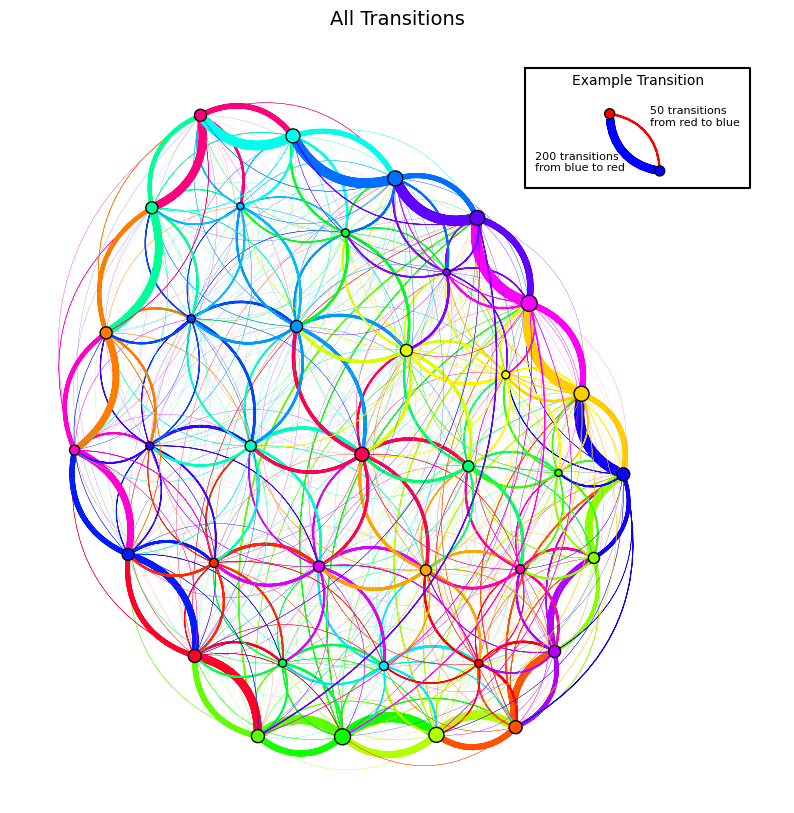

In [11]:
n_verticies = len(node_indices)
edges = [(node_indices.index(tuple(s)), node_indices.index(tuple(e))) for s, e in transitions]
edgeWeights = tcounts
vertexWeights = [sum(transitionCounts[n].values()) for n in node_indices]
print(max(vertexWeights))
vertexColors = color_list
# Edge color is the same as the node it originates from
edgeColors = [color_list[s] for s, e in edges]

# Add a transition example in upper right
n_verticies += 2
vertexWeights = np.append(vertexWeights, [350, 350])
vertexColors.extend(['#ff0000', '#0000ff'])
edges.extend([(37, 38), (38, 37)])
edgeWeights = np.append(edgeWeights, [50, 200])
edgeColors.extend(['#ff0000', '#0000ff'])
y_prime = np.append(y, [[50, 60], [60, 50]], axis=0)


# Removes all transitions that only happen once
#substantial_transition_idxs = np.array(edgeWeights != 1).nonzero()[0]
#edgeWeightsSubset = edgeWeights[substantial_transition_idxs]
#edgesSubset = np.array(edges)[substantial_transition_idxs


g = ig.Graph(n_verticies, edges)
layout = ig.Layout(coords=y_prime)

fig, ax = plt.subplots(figsize=(10,10))
plt.title("All Transitions", fontsize=14)
ig.plot(
    g,
    target = ax,
    layout = layout,
    vertex_size = [i * .03 for i in vertexWeights],
    vertex_color = vertexColors,
    edge_width = [i * .03 for i in edgeWeights],
    edge_color = edgeColors
)

plt.text(35, 50, "200 transitions\nfrom blue to red", fontsize=8)
plt.text(58, 58, "50 transitions\nfrom red to blue", fontsize=8)
plt.text(42.5, 65, "Example Transition", fontsize=10)
plt.plot([33, 33, 78, 78, 33], [68, 47, 47, 68, 68], color='k')

#plt.savefig('pdf_output/All_transitions.pdf')

### Plot Seasonal transitions

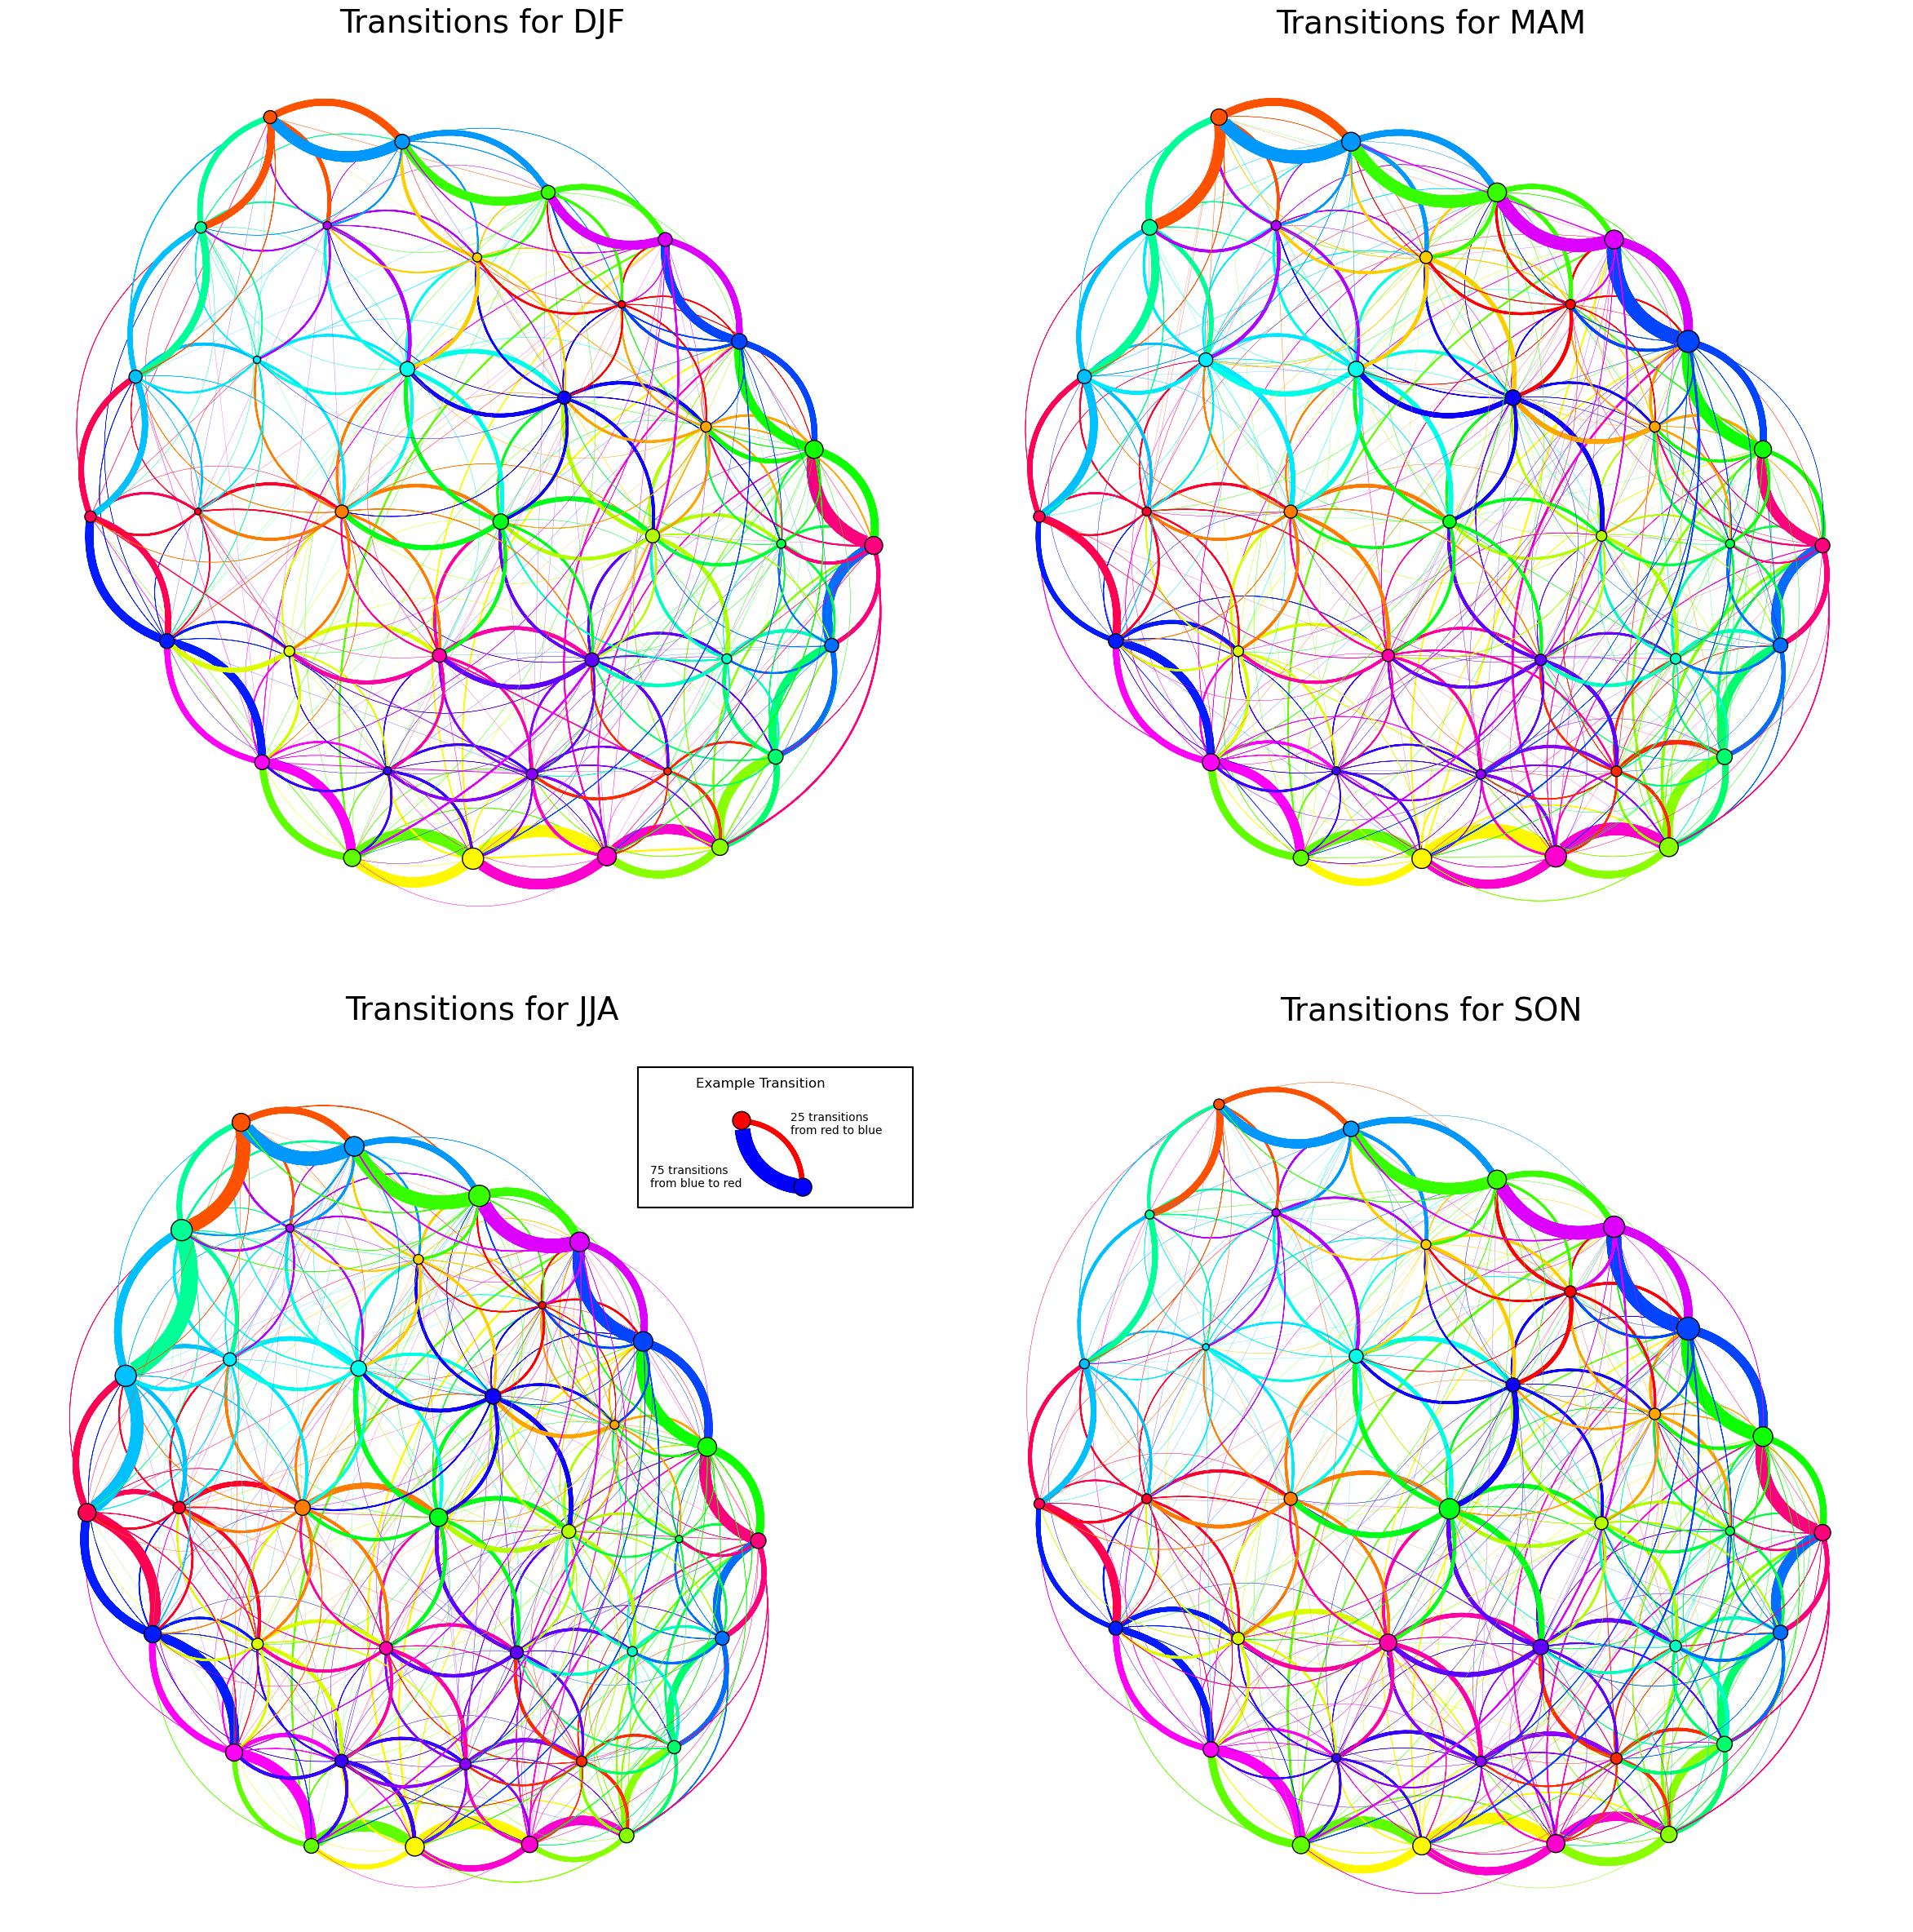

In [ ]:
seasonal_transitions = [(DJF_transitions, DJF_rawcounts, DJF_tcounts), 
               (MAM_transitions, MAM_rawcounts, MAM_tcounts),
               (JJA_transitions, JJA_rawcounts, JJA_tcounts),
               (SON_transitions, SON_rawcounts, SON_tcounts)]
seasonDict = {0: 'DJF', 1: 'MAM', 2: 'JJA', 3: 'SON'}

fig, axs = plt.subplots(2, 2, figsize=(30, 30))

for i in range(4):
    t = seasonal_transitions[i]
    ax = axs[i // 2, i % 2]
    
    n_verticies = len(node_indices)
    edges = [(node_indices.index(tuple(s)), node_indices.index(tuple(e))) for s, e in t[0]]
    edgeWeights = t[1]
    vertexWeights = [sum(t[2][n].values()) for n in node_indices]
    vertexColors = color_list
    
    # Edge color is the same as the node it originates from
    edgeColors = [color_list[s] for s, e in edges]
    
    # Add the transition example to one of the third axis (JJA)
    if i == 2:
        n_verticies += 2
        vertexWeights = np.append(vertexWeights, [125, 125])
        vertexColors.extend(['#ff0000', '#0000ff'])
        edges.extend([(37, 38), (38, 37)])
        edgeWeights = np.append(edgeWeights, [25, 75])
        edgeColors.extend(['#ff0000', '#0000ff'])
        y_prime = np.append(y, [[50, 60], [60, 50]], axis=0)
    
        g = ig.Graph(n_verticies, edges)
        layout = ig.Layout(coords=y_prime)
        
        ax.text(35, 50, "75 transitions\nfrom blue to red", fontsize=10)
        ax.text(58, 58, "25 transitions\nfrom red to blue", fontsize=10)
        ax.text(42.5, 65, "Example Transition", fontsize=12)
        ax.plot([33, 33, 78, 78, 33], [68, 47, 47, 68, 68], color='k')
    
    else:
        g = ig.Graph(n_verticies, edges)
        layout = ig.Layout(coords=y)
    
    ax.set_title(f"Transitions for {seasonDict[i]}", fontsize=28)
    ig.plot(
        g,
        target = ax,
        layout = layout,
        vertex_size = [i * .18 for i in vertexWeights],
        vertex_color = vertexColors,
        edge_width = [i * .18 for i in edgeWeights],
        edge_color = edgeColors
    )
    
plt.subplots_adjust(wspace=0.001, hspace=0.1)
#plt.savefig('pdf_output/Seasonal_transitions.pdf')

### Transition Distances

In [9]:
# convert our hex coordinates into cube coordinate
def oddr_to_cube(row, col):
    q = col - (row - (row&1)) / 2
    r = row
    return (q, r, -q-r)

# calculate the distance between two nodes
def calc_transition_distance(s, e):

    s = oddr_to_cube(s[0], s[1])
    e = oddr_to_cube(e[0], e[1])
    
    dist = (abs(s[0] - e[0]) + abs(s[1] - e[1]) + abs(s[2] - e[2])) / 2
    
    return dist

t_distances_counts = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
t_distances = {1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}}
t_distances_idx = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}

for i, t in enumerate(transitions_list):
    dist = calc_transition_distance(t[0], t[1])
    
    t_distances_counts[dist] += 1
    t_distances_idx[dist].append(i)

    k = (node_nums[tuple(t[0])], node_nums[tuple(t[1])])
    if k in t_distances[dist]:
        t_distances[dist][k] = t_distances[dist][k] + 1
    else:
        t_distances[dist][k] = 1
    
x = t_distances_counts[6] / sum(t_distances_counts.values())
print(x)


# Seasonal distances
DJF_distances_counts = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
MAM_distances_counts = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
JJA_distances_counts = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
SON_distances_counts = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}

for i, t in enumerate(DJF_tlist):
    dist = calc_transition_distance(t[0], t[1])
    DJF_distances_counts[dist] += 1
    
for i, t in enumerate(MAM_tlist):
    dist = calc_transition_distance(t[0], t[1])
    MAM_distances_counts[dist] += 1
    
for i, t in enumerate(JJA_tlist):
    dist = calc_transition_distance(t[0], t[1])
    JJA_distances_counts[dist] += 1
    
for i, t in enumerate(SON_tlist):
    dist = calc_transition_distance(t[0], t[1])
    SON_distances_counts[dist] += 1
    
print(DJF_distances_counts[6] / sum(DJF_distances_counts.values()))
print(MAM_distances_counts[6] / sum(MAM_distances_counts.values()))
print(JJA_distances_counts[6] / sum(JJA_distances_counts.values()))
print(SON_distances_counts[6] / sum(SON_distances_counts.values()))

0.009967005773989552
0.010749477455957002
0.00958641468090934
0.009446339543426921
0.010611561016475845


### A few examples of 6 distance transitions

Text(0.5, 1.05, 'node: (4, 6)')

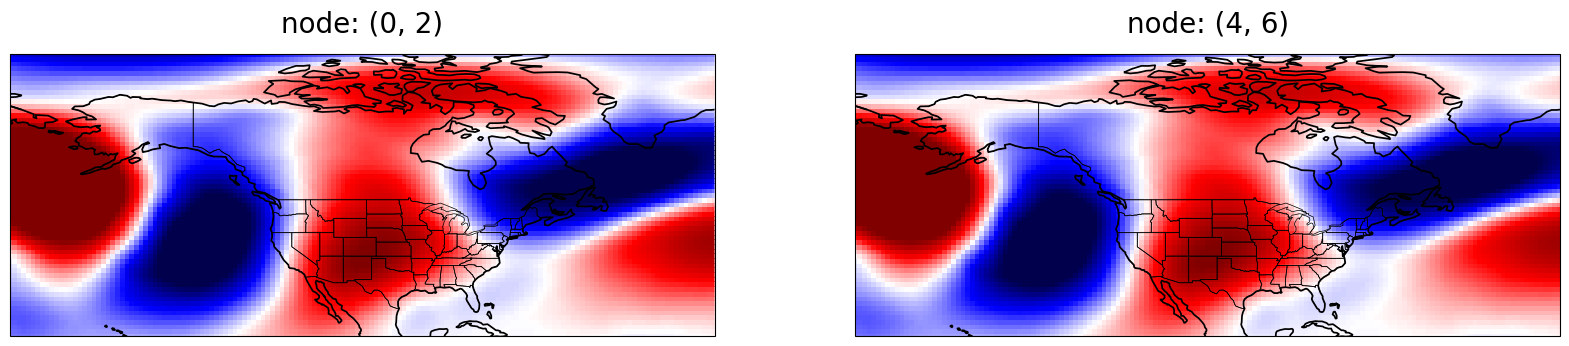

In [61]:
# Set up our lats and lons
lats = dataset.sel(lat=latSlice, lon=lonSlice).lat
lons = dataset.sel(lat=latSlice, lon=lonSlice).lon - 360
lons, lats = np.meshgrid(lons, lats)

# Set up our figure
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(20, 10))
axs = []

# Set up the subplots
axs.append(plt.subplot2grid((1, 2), (0, 0), 1, 1, projection=proj))
axs.append(plt.subplot2grid((1, 2), (0, 1), 1, 1, projection=proj))

# set up the background for each of the plots
for ax in axs:
    ax.set_extent([-180, -30, 20, 80], crs=proj)
    ax.coastlines(resolution='110m', color='k', linewidth=1.25, zorder=10)
    ax.margins(x=0, y=0)
    ax.add_feature(cfeature.STATES, facecolor='none', edgecolor='k', linewidth=0.5, zorder=10)
    ax.add_feature(cf.BORDERS, linewidth=0.5, zorder=10)
    
# get the data for the two days in the transition
t_idx = 1247
length_of_nodes = [len(list(g)) for k, g in itertools.groupby(neuronList)]
idx = sum(length_of_nodes[:t_idx + 1]) - 1
sdata = dataarray[idx].reshape((lons.shape[0], lats.shape[1]))
edata = dataarray[idx + 1].reshape((lons.shape[0], lats.shape[1]))

# plot the data for each day
axs[0].pcolor(lons, lats, sdata, vmin=minimum_weight, vmax=maximum_weight, cmap='seismic', shading='nearest', transform=proj)
axs[0].set_title(f'node: {neuronList[idx]}', fontsize=20, y=1.05)
axs[1].pcolor(lons, lats, sdata, vmin=minimum_weight, vmax=maximum_weight, cmap='seismic', shading='nearest', transform=proj)
axs[1].set_title(f'node: {neuronList[idx + 1]}', fontsize=20, y=1.05)


### Transition probabilities

In [28]:
tProbs = transitionProbs
avg = 0
max = 0
min = 1
count_over = 0

for s in tProbs:
    m = 0
    en = ''
    for e in tProbs[s]:
        if tProbs[s][e] > m:
            m = tProbs[s][e]
            en = e
            
            if m > max:
                max = m

    if m >= .40:
        count_over += 1
            
    print(f"{node_nums[s]} -> {node_nums[en]}: {m}")
    #print(f"{s} -> {en}: {m}")
    
    if m < min:
        min = m
    
    avg += m
    
print(f"max: {max}")
print(f"min: {min}")
print(f'count: {count_over}')

34 -> 35: 0.4737991266375546
35 -> 36: 0.44935543278084716
36 -> 37: 0.39122137404580154
37 -> 33: 0.3599137931034483
29 -> 34: 0.43237250554323725
30 -> 35: 0.19784172661870503
31 -> 32: 0.2064516129032258
32 -> 37: 0.2049469964664311
33 -> 28: 0.3704600484261501
23 -> 29: 0.37054631828978624
24 -> 25: 0.22741433021806853
25 -> 24: 0.1751269035532995
26 -> 25: 0.20052083333333334
27 -> 26: 0.2052980132450331
28 -> 22: 0.45614035087719296
16 -> 23: 0.4340659340659341
17 -> 18: 0.24907063197026022
18 -> 19: 0.21188630490956073
19 -> 12: 0.17697228144989338
20 -> 27: 0.1880108991825613
21 -> 20: 0.20491803278688525
22 -> 15: 0.5010845986984815
10 -> 16: 0.38480392156862747
11 -> 18: 0.21305841924398625
12 -> 19: 0.18854415274463007
13 -> 12: 0.1902439024390244
14 -> 13: 0.2140468227424749
15 -> 9: 0.4272030651340996
5 -> 10: 0.454320987654321
6 -> 12: 0.22764227642276422
7 -> 13: 0.20270270270270271
8 -> 13: 0.21212121212121213
9 -> 4: 0.4377224199288256
1 -> 5: 0.4632352941176471
2 -> 1

### Transitions Significance

In [8]:
significant_transitions = []

for node in node_indices:
    iters = 1000
    
    # List of the adjacent nodes 
    keys_list = []

    for node_end in node_indices:
        dist = calc_transition_distance(node, node_end)
        
        if dist == 1:
            keys_list.append(node_end)

    transition_list = [[k] * v for k, v in transitionCounts[node].items()]
    transition_list = [item for sublist in transition_list for item in sublist]
    
    transition_list = [i for i in transition_list if i in keys_list]
    
    n= len(transition_list)

    # Dictionary to store the samples for each iteration
    counts = {k: [] for k in keys_list}

    # Iterate
    for i in range(iters):
        
        # Dictionary to store the number of times each transition is sampled
        samples = {k: 0 for k in keys_list}
        
        # sample n times
        for j in range(n):
            
            # Take a random sample with replacement
            s = tuple(random.sample(keys_list, 1)[0])
            
            # Increment the count for the given transition sampled
            samples[s] += 1
            
        # Append the counts for this iteration to the dictionary
        for node_end in counts:
            counts[node_end].append(samples[node_end])

    max_sig = 0
    for node_end in counts:
        # Print out the node the transition goes to
        #print(f'Node: {node_nums[node_end]}')
        # Print out the percentile of our actual value for the transitions based on the sampled distribution
        #print(stats.percentileofscore(counts[node_end], transitionCounts[node][node_end]))
        
        percent = stats.percentileofscore(counts[node_end], transitionCounts[node][node_end])
        if percent >= .99:
            significant_transitions.append((node, node_end))
            
print(significant_transitions)
print(len(significant_transitions))
    

[((0, 2), (0, 3)), ((0, 2), (1, 1)), ((0, 3), (0, 2)), ((0, 3), (0, 4)), ((0, 4), (0, 3)), ((0, 4), (0, 5)), ((0, 5), (0, 4)), ((0, 5), (1, 5)), ((1, 1), (0, 2)), ((1, 1), (2, 1)), ((1, 2), (0, 2)), ((1, 2), (0, 3)), ((1, 2), (1, 1)), ((1, 2), (1, 3)), ((1, 3), (0, 4)), ((1, 3), (1, 2)), ((1, 3), (1, 4)), ((1, 3), (2, 3)), ((1, 4), (0, 5)), ((1, 4), (1, 3)), ((1, 4), (1, 5)), ((1, 4), (2, 4)), ((1, 5), (0, 5)), ((1, 5), (2, 6)), ((2, 1), (1, 1)), ((2, 1), (3, 0)), ((2, 2), (1, 1)), ((2, 2), (1, 2)), ((2, 2), (2, 1)), ((2, 2), (2, 3)), ((2, 2), (3, 2)), ((2, 3), (1, 2)), ((2, 3), (1, 3)), ((2, 3), (2, 2)), ((2, 3), (2, 4)), ((2, 3), (3, 3)), ((2, 4), (1, 4)), ((2, 4), (2, 3)), ((2, 4), (2, 5)), ((2, 4), (3, 3)), ((2, 5), (1, 5)), ((2, 5), (2, 4)), ((2, 5), (2, 6)), ((2, 5), (3, 4)), ((2, 6), (1, 5)), ((2, 6), (3, 6)), ((3, 0), (2, 1)), ((3, 0), (4, 1)), ((3, 1), (2, 1)), ((3, 1), (2, 2)), ((3, 1), (3, 0)), ((3, 1), (3, 2)), ((3, 1), (4, 1)), ((3, 2), (2, 2)), ((3, 2), (2, 3)), ((3, 2), 

In [163]:
print(edgeWeights)

[217 132 148 244 166 205 142 167 195 120  42  55  47  53  45  45  64  42
  28  58  36  58  50 101 153 156 128  51  43  58  73  34  48  64  69  66
  43  56  77  57  68  56  62  58  48  85 182 158 104  31  38  41  67  27
  49  57  57  82  42  65  74  78  78  83  69  69  46  53  27  41  50  36
  36  27 231 157 102  29  62  52  59  32  59  79  62  70  51  72  73  78
  52  44  33  38  64  37  32  34 131 223 184 102  42  56  39  30  32  58
  60  35  48  56  29  40  35  42  32 147 246 189 129 230 119 231 122 155
 245  50 200]


649
126


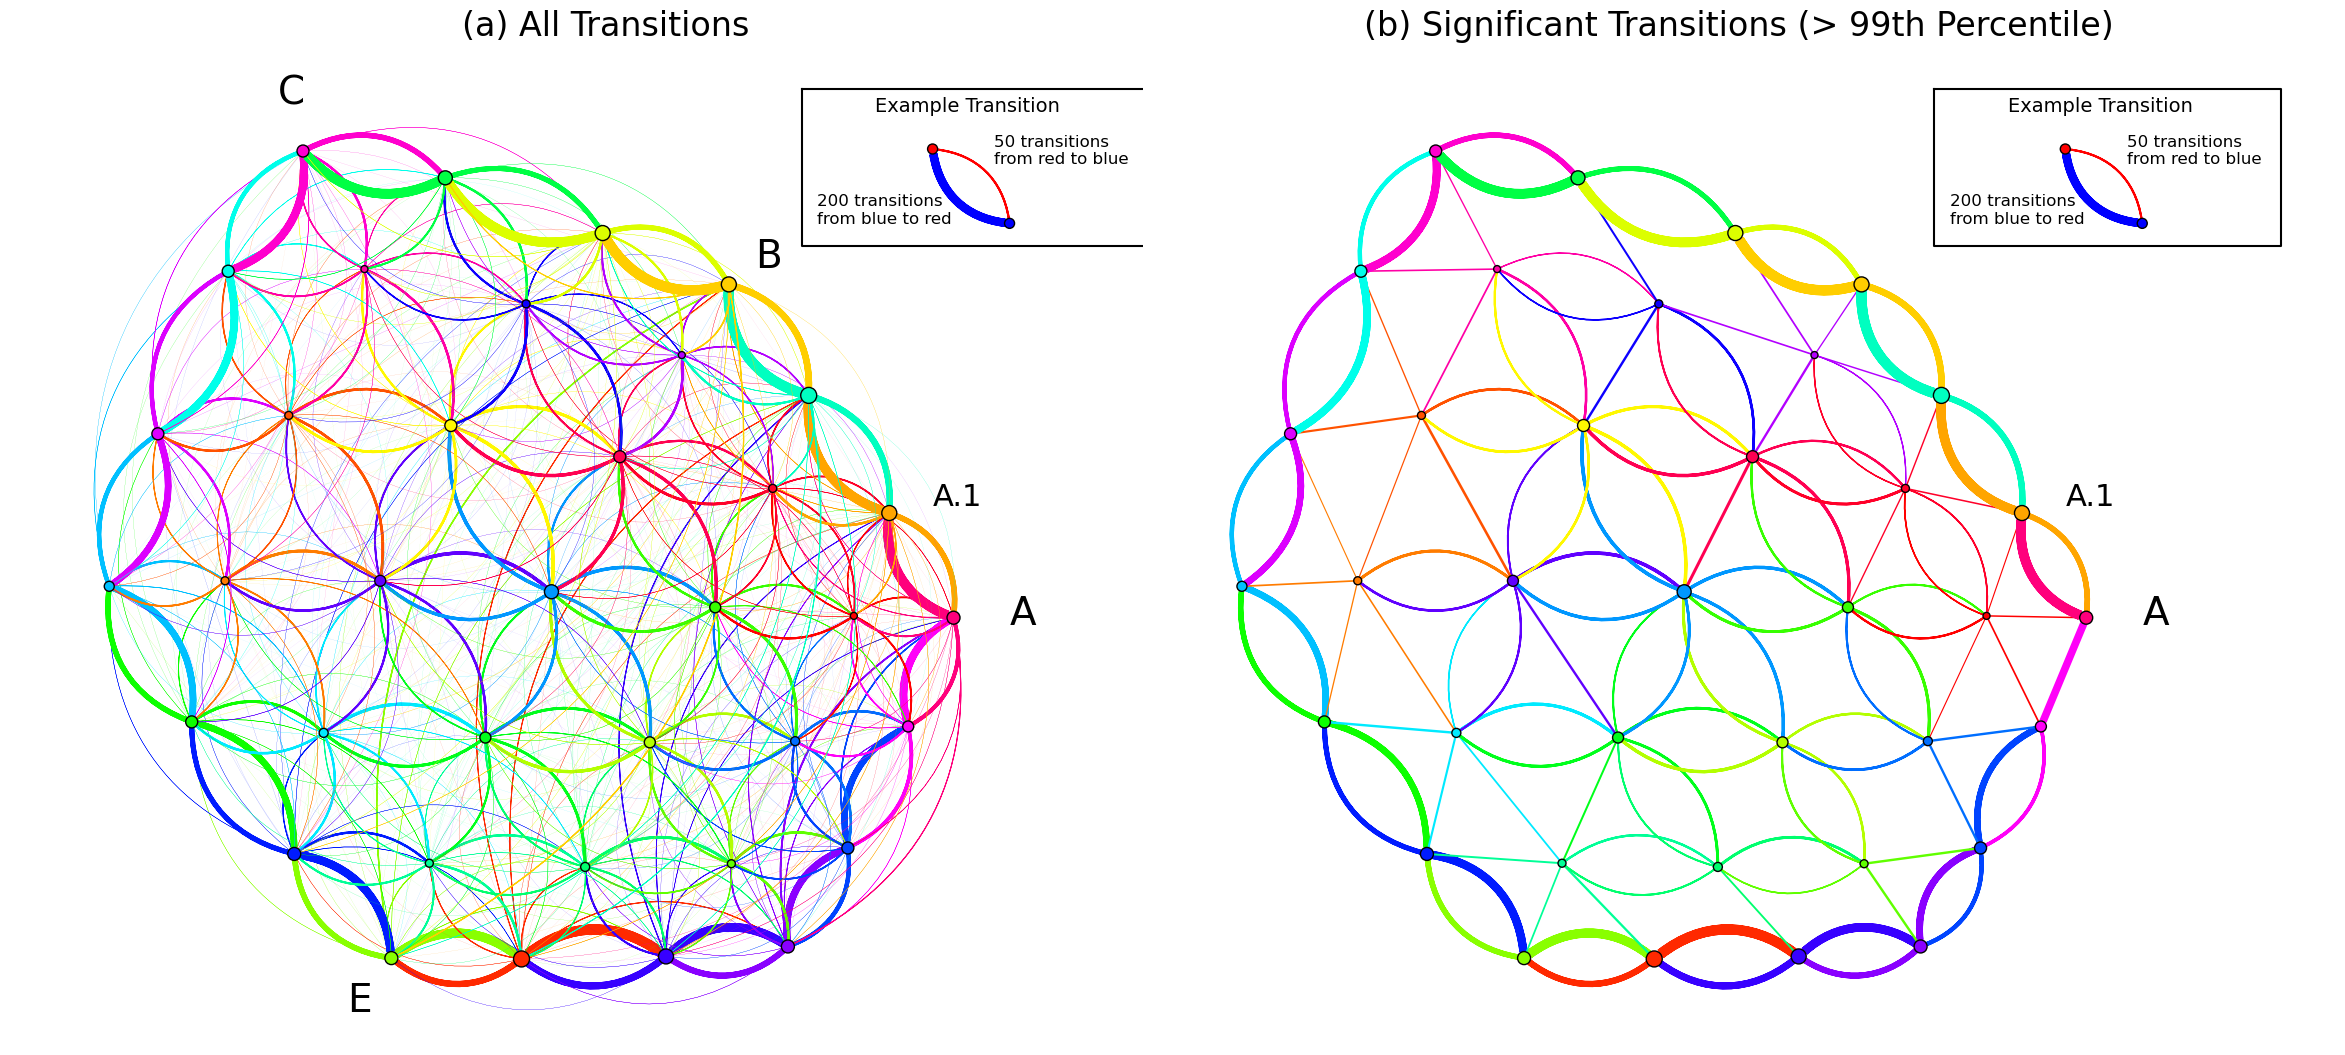

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(30, 13))

ax = axs[0]

n_verticies = len(node_indices)
edges = [(node_indices.index(tuple(s)), node_indices.index(tuple(e))) for s, e in transitions]
edgeWeights = tcounts
vertexWeights = [sum(transitionCounts[n].values()) for n in node_indices]
vertexColors = color_list
# Edge color is the same as the node it originates from
edgeColors = [color_list[s] for s, e in edges]

print(len(edgeWeights))

# Add a transition example in upper right
n_verticies += 2
vertexWeights = np.append(vertexWeights, [350, 350])
vertexColors.extend(['#ff0000', '#0000ff'])
edges.extend([(37, 38), (38, 37)])
edgeWeights = np.append(edgeWeights, [50, 200])
edgeColors.extend(['#ff0000', '#0000ff'])
y_prime = np.append(y, [[50, 60], [60, 50]], axis=0)

g = ig.Graph(n_verticies, edges)
layout = ig.Layout(coords=y_prime)

ax.set_title("(a) All Transitions", fontsize=24)
ig.plot(
    g,
    target = ax,
    layout = layout,
    vertex_size = [i * .03 for i in vertexWeights],
    vertex_color = vertexColors,
    edge_width = [i * .03 for i in edgeWeights],
    edge_color = edgeColors
)

ax = axs[1]

sig_edges = []
edgeWeights = []

for i, (s, e) in enumerate(transitions):
    if (tuple(s), tuple(e)) in significant_transitions:
        sig_edges.append((node_indices.index(tuple(s)), node_indices.index(tuple(e))))
        edgeWeights.append(tcounts[i])
     
n_verticies = len(node_indices)
vertexWeights = [sum(transitionCounts[n].values()) for n in node_indices]
vertexColors = color_list
# Edge color is the same as the node it originates from
edgeColors = [color_list[s] for s, e in sig_edges]

print(len(edgeWeights))

n_verticies += 2
vertexWeights = np.append(vertexWeights, [350, 350])
vertexColors.extend(['#ff0000', '#0000ff'])
sig_edges.extend([(37, 38), (38, 37)])
edgeWeights = np.append(edgeWeights, [50, 200])
edgeColors.extend(['#ff0000', '#0000ff'])
y_prime = np.append(y, [[50, 60], [60, 50]], axis=0)

# Create the graph object
g = ig.Graph(n_verticies, sig_edges)
layout = ig.Layout(coords=y_prime)

ax.set_title("(b) Significant Transitions (> 99th Percentile)", fontsize=24)
ig.plot(
    g,
    target = ax,
    layout = layout,
    vertex_size = [i * .03 for i in vertexWeights],
    vertex_color = vertexColors,
    edge_width = [i * .03 for i in edgeWeights],
    edge_color = edgeColors
)

ax.text(35, 50, "200 transitions\nfrom blue to red", fontsize=12)
ax.text(58, 58, "50 transitions\nfrom red to blue", fontsize=12)
ax.text(42.5, 65, "Example Transition", fontsize=14)
ax.plot([33, 33, 78, 78, 33], [68, 47, 47, 68, 68], color='k')

axs[0].text(35, 50, "200 transitions\nfrom blue to red", fontsize=12)
axs[0].text(58, 58, "50 transitions\nfrom red to blue", fontsize=12)
axs[0].text(42.5, 65, "Example Transition", fontsize=14)
axs[0].plot([33, 33, 78, 78, 33], [68, 47, 47, 68, 68], color='k', zorder=500)
axs[0].text(60, -4, "A", fontsize=28)
axs[0].text(50, 12, "A.1", fontsize=22)
axs[0].text(27, 44, "B", fontsize=28)
axs[0].text(-35, 66, "C", fontsize=28)
axs[0].text(-26, -56, "E", fontsize=28)

axs[1].text(60, -4, "A", fontsize=28)
axs[1].text(50, 12, "A.1", fontsize=22)

plt.subplots_adjust(wspace=-.05)
plt.savefig('pdf_output/transitions.pdf')

In [30]:
color_list = generate_distinct_colors(len(node_indices))

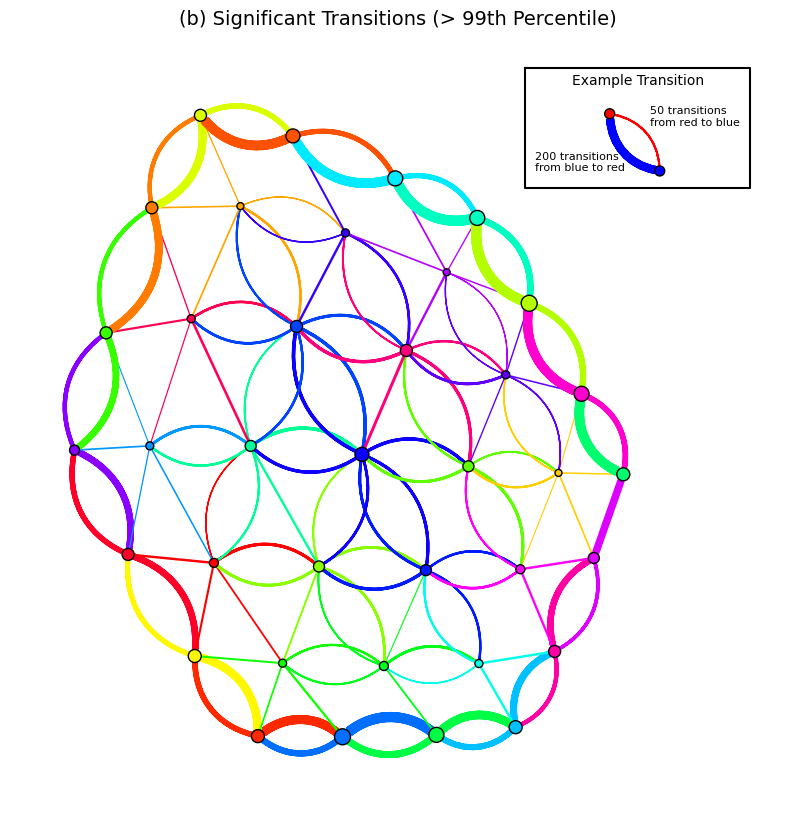

In [ ]:
sig_edges = []
edgeWeights = []

for i, (s, e) in enumerate(transitions):
    if (tuple(s), tuple(e)) in significant_transitions:
        sig_edges.append((node_indices.index(tuple(s)), node_indices.index(tuple(e))))
        edgeWeights.append(tcounts[i])
     
n_verticies = len(node_indices)
vertexWeights = [sum(transitionCounts[n].values()) for n in node_indices]
vertexColors = color_list
# Edge color is the same as the node it originates from
edgeColors = [color_list[s] for s, e in sig_edges]

n_verticies += 2
vertexWeights = np.append(vertexWeights, [350, 350])
vertexColors.extend(['#ff0000', '#0000ff'])
sig_edges.extend([(37, 38), (38, 37)])
edgeWeights = np.append(edgeWeights, [50, 200])
edgeColors.extend(['#ff0000', '#0000ff'])
y_prime = np.append(y, [[50, 60], [60, 50]], axis=0)

# Create the graph object
g = ig.Graph(n_verticies, sig_edges)
layout = ig.Layout(coords=y_prime)

fig, ax = plt.subplots(figsize=(10,10))
plt.title("(b) Significant Transitions (> 99th Percentile)", fontsize=14)
ig.plot(
    g,
    target = ax,
    layout = layout,
    vertex_size = [i * .03 for i in vertexWeights],
    vertex_color = vertexColors,
    edge_width = [i * .03 for i in edgeWeights],
    edge_color = edgeColors
)

plt.text(35, 50, "200 transitions\nfrom blue to red", fontsize=8)
plt.text(58, 58, "50 transitions\nfrom red to blue", fontsize=8)
plt.text(42.5, 65, "Example Transition", fontsize=10)
plt.plot([33, 33, 78, 78, 33], [68, 47, 47, 68, 68], color='k')

### Seasonal Transition Significance

In [25]:
def calc_seasonal_transition_significance(season_tcounts, percentile=.99):

    seasonal_significant_transitions = []

    for node in node_indices:
        iters = 1000
        
        # List of the adjacent nodes 
        keys_list = []

        for node_end in node_indices:
            dist = calc_transition_distance(node, node_end)
            
            if dist == 1:
                keys_list.append(node_end)

        transition_list = [[k] * v for k, v in season_tcounts[node].items()]
        transition_list = [item for sublist in transition_list for item in sublist]
        
        transition_list = [i for i in transition_list if i in keys_list]
        
        n = len(transition_list)

        # Dictionary to store the samples for each iteration
        counts = {k: [] for k in keys_list}

        # Iterate
        for i in range(iters):
            
            # Dictionary to store the number of times each transition is sampled
            samples = {k: 0 for k in keys_list}
            
            # sample n times
            for j in range(n):
                
                # Take a random sample with replacement
                s = tuple(random.sample(keys_list, 1)[0])
                
                # Increment the count for the given transition sampled
                samples[s] += 1
                
            # Append the counts for this iteration to the dictionary
            for node_end in counts:
                counts[node_end].append(samples[node_end])

        for node_end in counts:
            if node_end in season_tcounts[node]:
            
                percent = stats.percentileofscore(counts[node_end], season_tcounts[node][node_end])
                if percent >= percentile:
                    seasonal_significant_transitions.append((node, node_end))
                
    return seasonal_significant_transitions

def subset_transitions_counts(trans, sig_trans, trans_counts):
    sig_edges = []
    sig_weights = []

    for i, (s, e) in enumerate(trans):
        if (tuple(s), tuple(e)) in sig_trans:
            sig_edges.append((node_indices.index(tuple(s)), node_indices.index(tuple(e))))
            sig_weights.append(trans_counts[tuple(s)][tuple(e)])
            
    return sig_edges, sig_weights

In [26]:
DJF_sig_trans = calc_seasonal_transition_significance(DJF_tcounts)
MAM_sig_trans = calc_seasonal_transition_significance(MAM_tcounts)
JJA_sig_trans = calc_seasonal_transition_significance(JJA_tcounts)
SON_sig_trans = calc_seasonal_transition_significance(SON_tcounts)

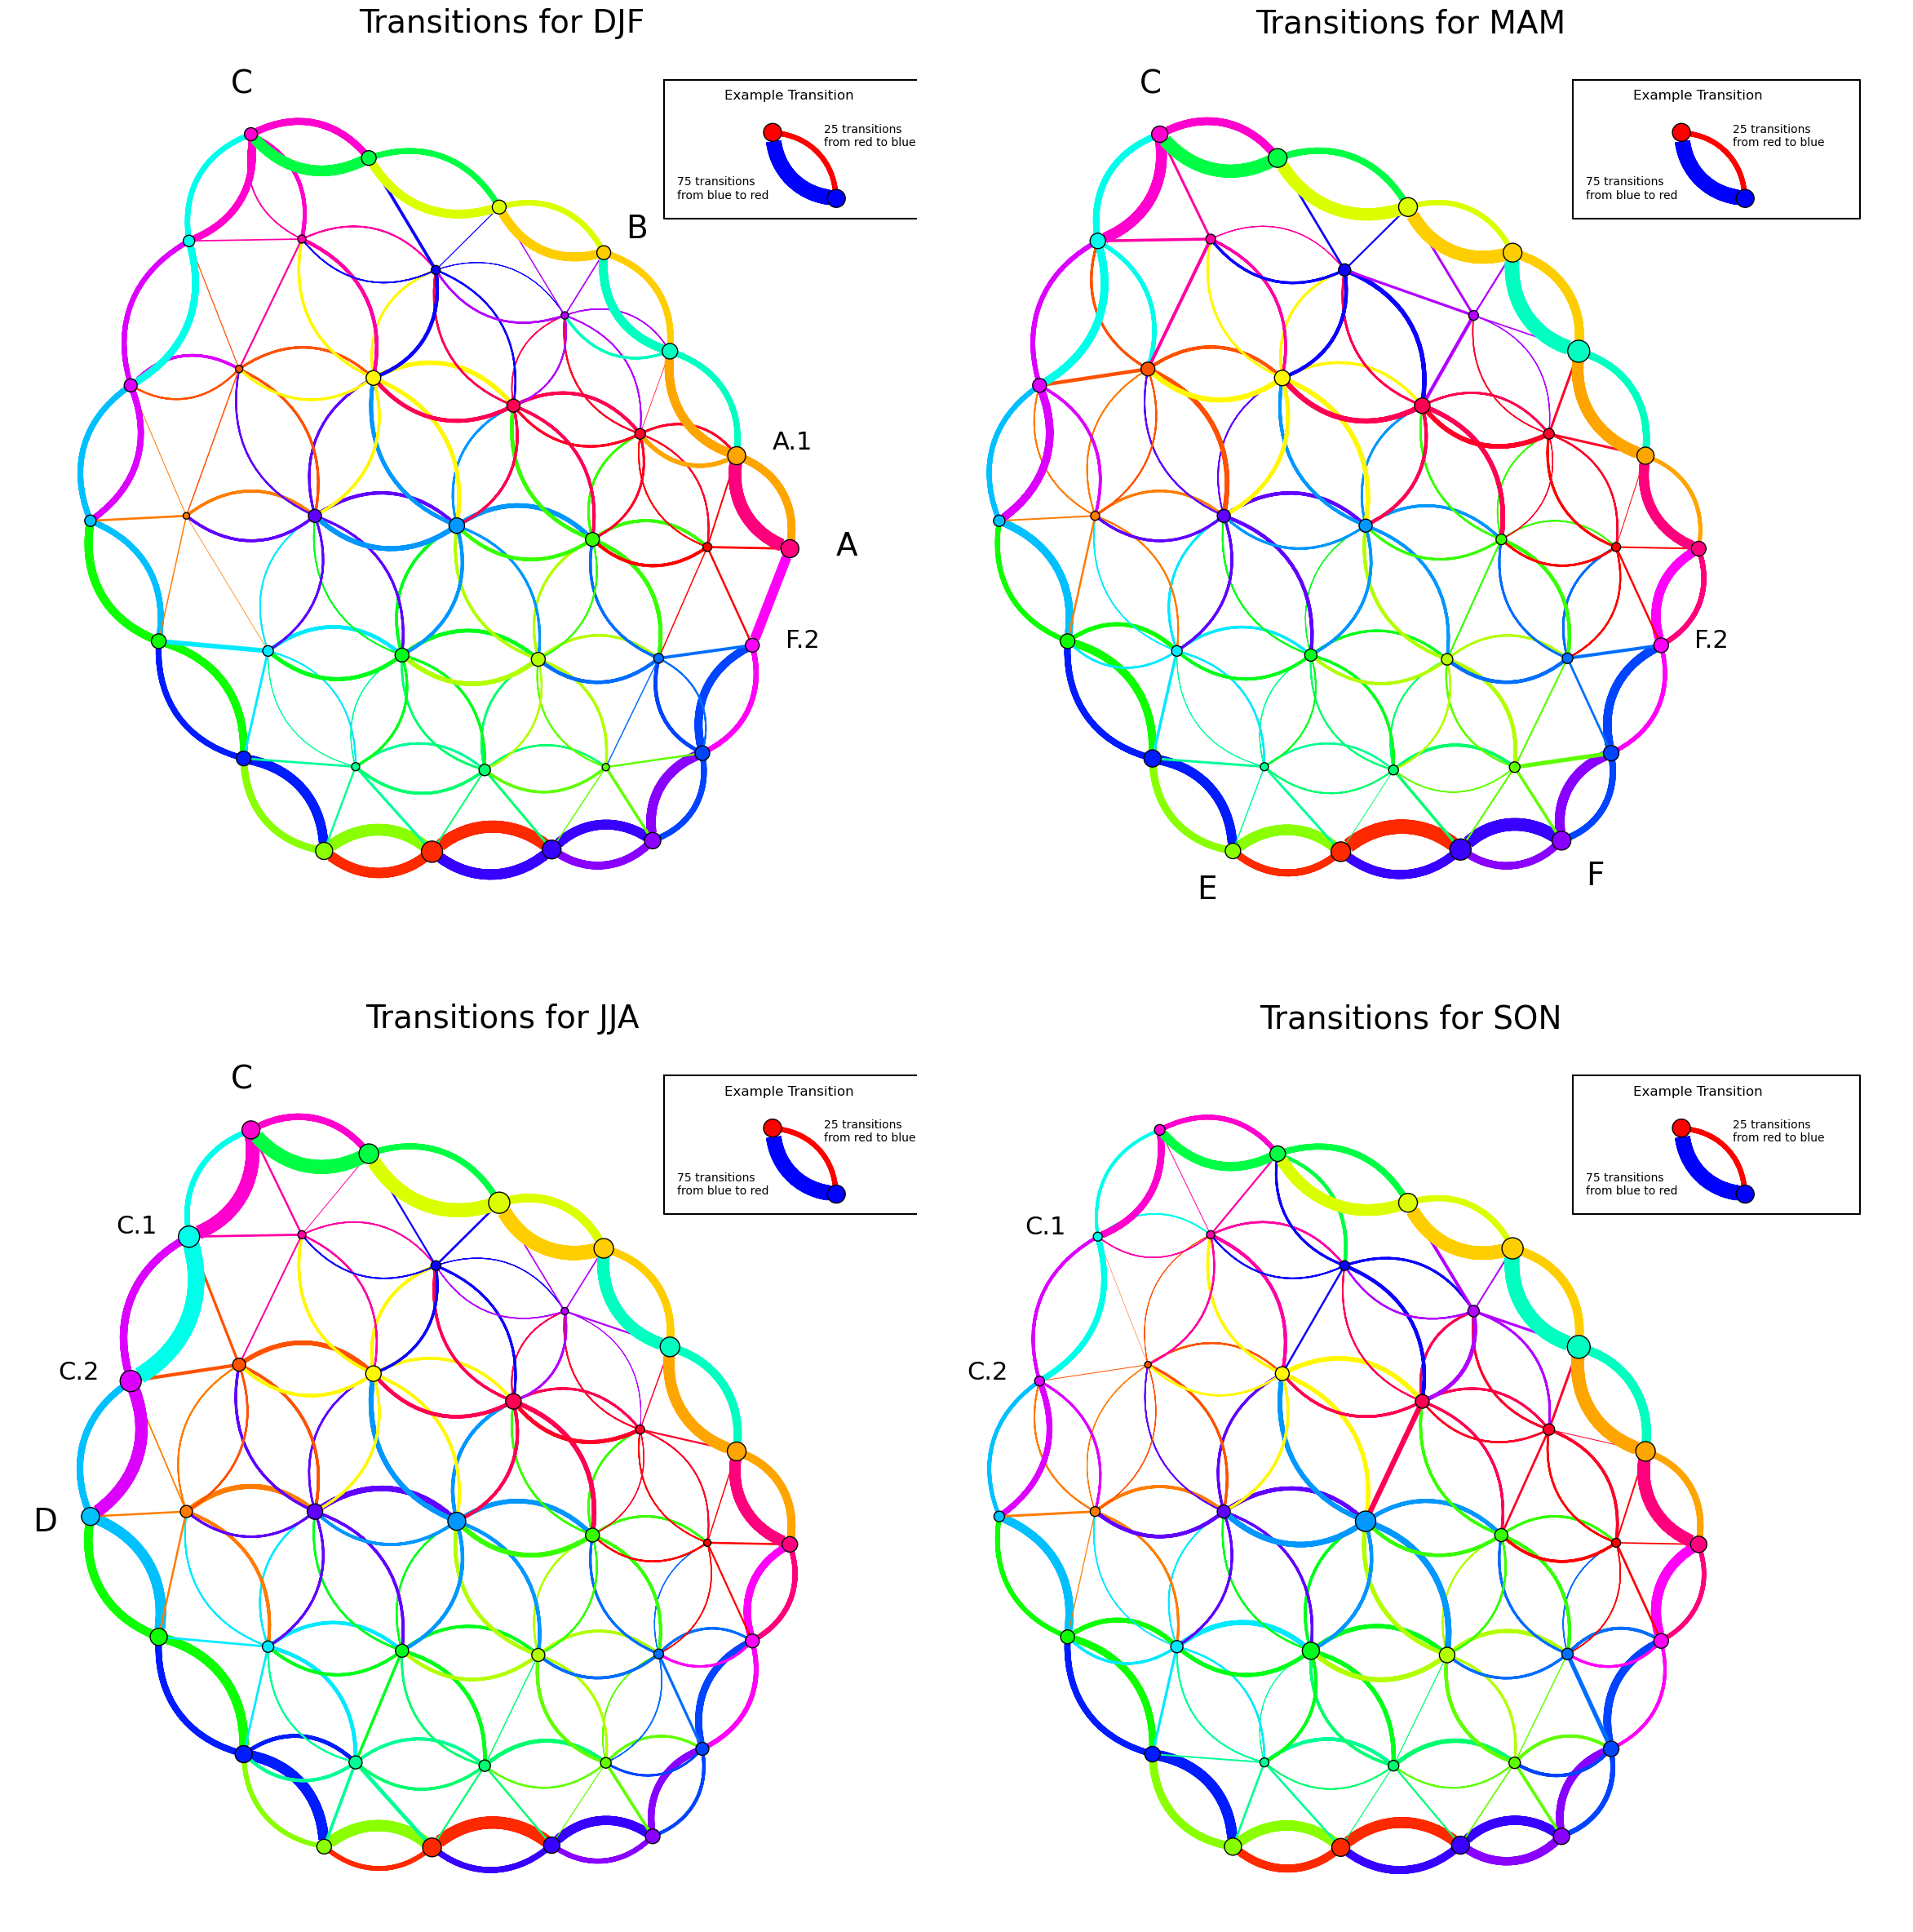

In [32]:
DJF_sig_transitions, DJF_sig_tcounts = subset_transitions_counts(DJF_sig_trans, DJF_sig_trans, DJF_tcounts)
MAM_sig_transitions, MAM_sig_tcounts = subset_transitions_counts(MAM_transitions, MAM_sig_trans, MAM_tcounts)
JJA_sig_transitions, JJA_sig_tcounts = subset_transitions_counts(JJA_transitions, JJA_sig_trans, JJA_tcounts)
SON_sig_transitions, SON_sig_tcounts = subset_transitions_counts(SON_transitions, SON_sig_trans, SON_tcounts)

seasonal_transitions = [(DJF_sig_transitions, DJF_sig_tcounts, DJF_tcounts), 
                        (MAM_sig_transitions, MAM_sig_tcounts, MAM_tcounts),
                        (JJA_sig_transitions, JJA_sig_tcounts, JJA_tcounts),
                        (SON_sig_transitions, SON_sig_tcounts, SON_tcounts)]
seasonDict = {0: 'DJF', 1: 'MAM', 2: 'JJA', 3: 'SON'}

fig, axs = plt.subplots(2, 2, figsize=(30, 30))

for i in range(4):
    t = seasonal_transitions[i]
    ax = axs[i // 2, i % 2]
    
    n_verticies = len(node_indices)
    edges = t[0]
    edgeWeights = t[1]
    vertexWeights = [sum(t[2][n].values()) for n in node_indices]
    vertexColors = color_list
    
    # Edge color is the same as the node it originates from
    edgeColors = [color_list[s] for s, e in edges]
    
    # Add the transition example to one of the third axis (JJA)
    n_verticies += 2
    vertexWeights = np.append(vertexWeights, [125, 125])
    vertexColors.extend(['#ff0000', '#0000ff'])
    edges.extend([(37, 38), (38, 37)])
    edgeWeights = np.append(edgeWeights, [25, 75])
    edgeColors.extend(['#ff0000', '#0000ff'])
    y_prime = np.append(y, [[50, 60], [60, 50]], axis=0)

    g = ig.Graph(n_verticies, edges)
    layout = ig.Layout(coords=y_prime)
    
    ax.text(35, 50, "75 transitions\nfrom blue to red", fontsize=10)
    ax.text(58, 58, "25 transitions\nfrom red to blue", fontsize=10)
    ax.text(42.5, 65, "Example Transition", fontsize=12)
    ax.plot([33, 33, 78, 78, 33], [68, 47, 47, 68, 68], color='k')
    
    #else:
    g = ig.Graph(n_verticies, edges)
    layout = ig.Layout(coords=y_prime)

    ax.set_title(f"Transitions for {seasonDict[i]}", fontsize=28)
    ig.plot(
        g,
        target = ax,
        layout = layout,
        vertex_size = [i * .18 for i in vertexWeights],
        vertex_color = vertexColors,
        edge_width = [i * .18 for i in edgeWeights],
        edge_color = edgeColors
    )
    
# DJF Labels
axs[0, 0].text(60, -4, "A", fontsize=28)
axs[0, 0].text(50, 12, "A.1", fontsize=22)
axs[0, 0].text(52, -18, "F.2", fontsize=22)
axs[0, 0].text(27, 44, "B", fontsize=28)
axs[0, 0].text(-35, 66, "C", fontsize=28)

# MAM labels
axs[0, 1].text(-35, 66, "C", fontsize=28)
axs[0, 1].text(-26, -56, "E", fontsize=28)
axs[0, 1].text(35, -54, "F", fontsize=28)
axs[0, 1].text(52, -18, "F.2", fontsize=22)

# JJA labels
axs[1, 0].text(-35, 66, "C", fontsize=28)
axs[1, 0].text(-53, 44, "C.1", fontsize=22)
axs[1, 0].text(-62, 22, "C.2", fontsize=22)
axs[1, 0].text(-66, -1, "D", fontsize=28)

# SON labels
axs[1, 1].text(-53, 44, "C.1", fontsize=22)
axs[1, 1].text(-62, 22, "C.2", fontsize=22)

plt.subplots_adjust(wspace=-.08, hspace=.12)
plt.savefig('pdf_output/Seasonal_transitions.pdf')